In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
ratings = "ratings25m.csv"

In [3]:
import csv

with open(ratings) as r:
    ratings_reader = csv.reader(r)
    next(ratings_reader)
    ratings_reader = list(ratings_reader)

In [4]:
len(ratings_reader)

25000095

In [5]:
# Create the data structure

map_user_to_index={}
map_index_to_user=[]

map_movie_to_index={}
map_index_to_movie=[]

data_by_user_index = []
data_by_movie_index = []


user_index = 0
movie_index = 0

for i in ratings_reader:
    us_index = int(i[0])
    mov_index = int(i[1])
    rat_index = float(i[2])

    if us_index not in map_user_to_index:
        map_user_to_index[us_index] = user_index
        map_index_to_user.append(us_index)
        data_by_user_index.append([])
        user_index += 1

    if mov_index not in map_movie_to_index:
        map_movie_to_index[mov_index] = movie_index
        map_index_to_movie.append(mov_index)
        data_by_movie_index.append([])
        movie_index += 1

    up_user_index = map_user_to_index[us_index]
    up_movie_index = map_movie_to_index[mov_index]

    data_by_user_index[up_user_index].append((up_movie_index, rat_index))
    data_by_movie_index[up_movie_index].append((up_user_index, rat_index))


# Degree distribution

In [10]:
degree_user = [len(i) for i in data_by_user_index]
degree_item = [len(j) for j in data_by_movie_index]

freq_user = [degree_user.count(k) for k in degree_user]
freq_item = [degree_item.count(l) for l in degree_item]

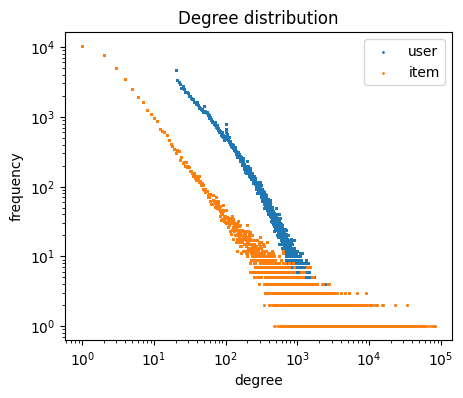

In [8]:
fig, ax = plt.subplots(figsize = (5, 4))

ax.scatter(np.array(degree_user), np.array(freq_user), s=1, label = 'user')
ax.scatter(np.array(degree_item), np.array(freq_item), s=1, label = 'item')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('degree')
ax.set_ylabel('frequency')
ax.set_title('Degree distribution')
ax.legend();

plt.savefig('power_law.pdf', format='pdf')

In [6]:
data_by_user_index45 = [[j for j in i if j[1] >= 4] for i in data_by_user_index]
data_by_movie_index45 = [[j for j in i if j[1] >= 4] for i in data_by_movie_index]

In [7]:
degree_user45 = [len(i) for i in data_by_user_index45]
degree_item45 = [len(j) for j in data_by_movie_index45]

freq_user45 = [degree_user45.count(k) for k in degree_user45]
freq_item45 = [degree_item45.count(l) for l in degree_item45]

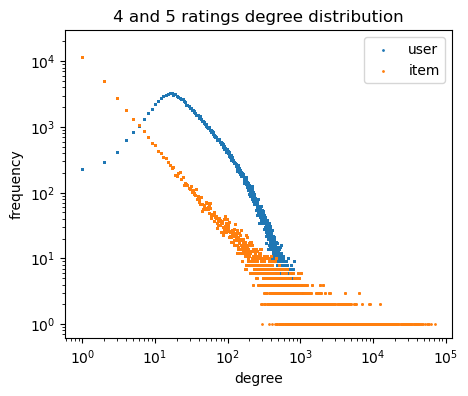

In [8]:
fig, ax = plt.subplots(figsize = (5, 4))

ax.scatter(degree_user45, freq_user45, s=1, label = 'user')
ax.scatter(degree_item45, freq_item45, s=1, label = 'item')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('degree')
ax.set_ylabel('frequency')
ax.set_title('4 and 5 ratings degree distribution')
ax.legend();

plt.savefig('power_law45.pdf', format='pdf')

# Rating distributions

In [12]:
ratings_reader[:5]

[['1', '296', '5.0', '1147880044'],
 ['1', '306', '3.5', '1147868817'],
 ['1', '307', '5.0', '1147868828'],
 ['1', '665', '5.0', '1147878820'],
 ['1', '899', '3.5', '1147868510']]

In [ ]:
rating_dist = [row[2] for row in ratings]
rating_dist.sort()


# Plotting a basic histogram
plt.hist(rating_dist, bins=len(set(rating_dist)))
 
# Adding labels and title
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Rating distribution')

# Display the plot
#plt.show()
#plt.savefig('rating_distribution.pdf', format='pdf')

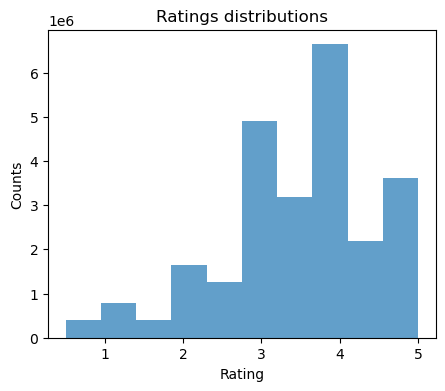

In [ ]:
all_ratings = [float(i[2]) for i in ratings_reader]
all_ratings.sort()
bins = np.arange(0.5, 5.5, 0.5)

fig, ax = plt.subplots(figsize=(5, 4))

ax.hist(all_ratings, bins=len(set(all_ratings)), alpha=.7)
ax.set_xlabel('Rating')
ax.set_ylabel('Counts')
ax.set_title('Ratings distributions');

plt.savefig('rating_distr.pdf', format='pdf')

# Split the data into test and training set

In [7]:
def split_into_train_and_test(data, split_value=0.1):

  data_train = []
  data_test = []

  for i in range(len(data)):
    data_train.append([])
    data_test.append([])

    for j in data[i]:
      if np.random.rand() < split_value:
        data_test[i].append(j)
      else:
        data_train[i].append(j)

  return data_train, data_test

In [8]:
# Spit the data into training and test setplt
data_by_user_train, data_by_user_test = split_into_train_and_test(data_by_user_index)
data_by_item_train, data_by_item_test = split_into_train_and_test(data_by_movie_index)

print(len(data_by_user_index))
print(len(data_by_user_train))
print(len(data_by_user_test))

162541
162541
162541


In [9]:
print(len(data_by_movie_index))
print(len(data_by_item_train))
print(len(data_by_item_test))

59047
59047
59047


In [10]:
len(map_user_to_index) # number of users
print(len(map_movie_to_index)) # number of movies

59047


# Training

## Bias only

In [24]:
def compute_loss_and_rmse_bias_only(
  data_by_usr,
  data_by_itm,
  user_biases,
  item_biases,
  lambd = 0.01,
  gamma = 0.01,
  epoch = 50,
  ):

  all_loss = []
  all_rmse = []

  for i in range(epoch):
    # Update user biases
    for m in range(len(data_by_usr)):
        bias = 0
        item_counter = 0
        for (n, r) in data_by_usr[m]:
            bias += lambd * (r - item_biases[n])
            item_counter += 1

        bias = bias / (lambd * item_counter + gamma)
        user_biases[m] = bias

    # Update item biases
    for n in range(len(data_by_itm)):
        bias = 0
        user_counter = 0
        for (m, r) in data_by_itm[n]:
            bias += lambd * (r - user_biases[m])
            user_counter += 1

        bias = bias / (lambd * user_counter + gamma)
        item_biases[n] = bias

    # Compute loss after updating biases
    loss_one = 0
    rmse_one = 0
    counter = 0
    for m in range(len(data_by_usr)):
        for (n, r) in data_by_usr[m]:
            error = r - user_biases[m] - item_biases[n]
            loss_one += ( lambd / 2) * (error ** 2) + (gamma / 2) * (user_biases[m] ** 2 + item_biases[n] ** 2)
            rmse_one += error**2
            counter += 1

    rmse_one = np.sqrt(rmse_one / counter)

    print(f"Epoch {i}: loss = {loss_one}, rmse = {rmse_one}")

    # Store loss for this iteration
    all_loss.append(loss_one)
    all_rmse.append(rmse_one)

  return all_loss, all_rmse


In [10]:
epochs = 10; lambd = 0.01; gamma = 0.0001

In [15]:
loss_bias_train, rmse_bias_train = compute_loss_and_rmse_bias_only(
                            data_by_usr = data_by_user_train,
  	                        data_by_itm = data_by_item_train,
                            user_biases = np.zeros(len(data_by_user_train)),
  	                        item_biases = np.zeros(len(data_by_item_train)),
                            lambd = lambd,
  	                        gamma = gamma,
  	                        epoch = epochs,
                            )


Epoch 0: loss = 98875.0154497772, rmse = 0.8661331656962153
Epoch 1: loss = 95941.1279002036, rmse = 0.8508614451526314
Epoch 2: loss = 95810.92749627723, rmse = 0.8501305500375355
Epoch 3: loss = 95802.58307823545, rmse = 0.8500811560203074
Epoch 4: loss = 95800.2831881527, rmse = 0.8500755163738767
Epoch 5: loss = 95798.25722342316, rmse = 0.8500744719594879
Epoch 6: loss = 95796.21102237747, rmse = 0.850074214982781
Epoch 7: loss = 95794.1448906313, rmse = 0.8500741365688498
Epoch 8: loss = 95792.0688614535, rmse = 0.8500741060037651
Epoch 9: loss = 95789.98850590583, rmse = 0.85007409031629


In [16]:
loss_bias_test, rmse_bias_test = compute_loss_and_rmse_bias_only(
                            data_by_usr = data_by_user_test,
  	                        data_by_itm = data_by_item_test,
                            user_biases = np.zeros(len(data_by_user_test)),
  	                        item_biases = np.zeros(len(data_by_item_test)),
                            lambd = lambd,
  	                        gamma = gamma,
  	                        epoch = epochs,
                            )

Epoch 0: loss = 10631.679486857454, rmse = 0.8498148052818143
Epoch 1: loss = 10216.567982383005, rmse = 0.8306476426302186
Epoch 2: loss = 10187.53828128783, rmse = 0.8298548154113574
Epoch 3: loss = 10172.718927437003, rmse = 0.8297811639727645
Epoch 4: loss = 10158.787523775869, rmse = 0.829751386736324
Epoch 5: loss = 10145.16948888517, rmse = 0.8297289126592496
Epoch 6: loss = 10131.818624360292, rmse = 0.8297095013428553
Epoch 7: loss = 10118.718176224864, rmse = 0.8296919584155946
Epoch 8: loss = 10105.858304998626, rmse = 0.829675819015484
Epoch 9: loss = 10093.232457903789, rmse = 0.8296608805530735


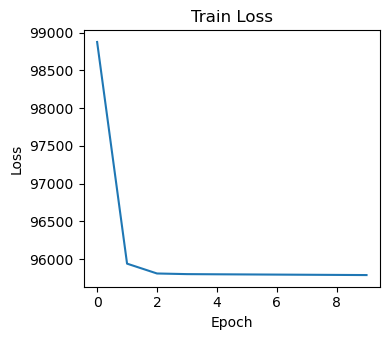

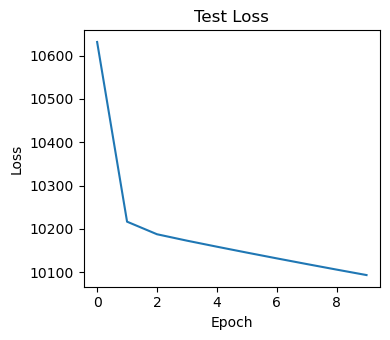

In [ ]:
loss_bias_train = np.array([98875.0154497772, 95941.1279002036, 95810.92749627723, 95802.58307823545, 95800.2831881527, 95798.25722342316, 95796.21102237747, 95794.1448906313, 95792.0688614535, 95789.98850590583])
loss_bias_test = np.array([10631.679486857454, 10216.567982383005, 10187.53828128783, 10172.718927437003, 10158.787523775869, 10145.16948888517, 10131.818624360292, 10118.718176224864, 10105.858304998626, 10093.232457903789])

epochs = 10

# Train Loss
fig1, ax1 = plt.subplots(figsize=(4, 3.5))
ax1.plot(list(range(epochs)), loss_bias_train, label='Train Loss')
ax1.set_title('Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
plt.tight_layout()
plt.savefig('loss_train_25bias.pdf', format='pdf')

# Test Loss
fig2, ax2 = plt.subplots(figsize=(4, 3.5))
ax2.plot(list(range(epochs)), loss_bias_test, label='Test Loss')
ax2.set_title('Test Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
plt.tight_layout()
plt.savefig('loss_test_25bias.pdf', format='pdf')

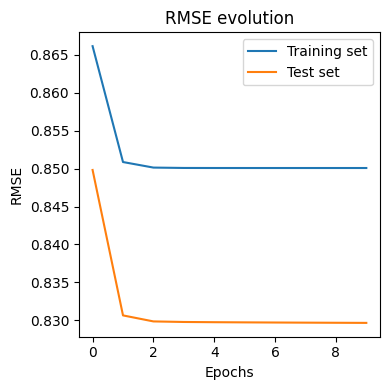

In [18]:
# plot
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(list(range(epochs)), rmse_bias_train, label='Training set')
ax.plot(list(range(epochs)), rmse_bias_test, label='Test set')
ax.set_title('RMSE evolution')
ax.set_xlabel('Epochs')
ax.set_ylabel('RMSE')
ax.legend()

plt.tight_layout();
plt.savefig('rmse_train_test_25bias.pdf', format='pdf')

## With latent space vectors

In [11]:
def compute_loss_and_rmse_with_embeddings(
    data_by_usr,
    data_by_itm,
    user_biases,
    item_biases,
    lambd=0.1,
    gamma=0.2,
    tau=0.5,
    K=4,
    epoch=20,
):
    # Initialisation
    user_vector = np.random.normal(0, 1/np.sqrt(K), (len(data_by_usr), K))
    item_vector = np.random.normal(0, 1/np.sqrt(K), (len(data_by_itm), K))

    all_loss = np.zeros(epoch)
    all_rmse = np.zeros(epoch)

    for i in range(epoch):
        for m, user_ratings in enumerate(data_by_usr):
            # Update user biases
            bias_sum = np.sum([r - user_vector[m] @ item_vector[n] - item_biases[n] for n, r in user_ratings])
            user_biases[m] = bias_sum / (len(user_ratings) + gamma)

            # Update user vectors
            sum1 = np.zeros((K, K))
            sum2 = np.zeros(K)
            for n, r in user_ratings:
                item_vec = item_vector[n]
                sum1 += np.outer(item_vec, item_vec)
                sum2 += item_vec * (r - user_biases[m] - item_biases[n])

            user_vector[m] = np.linalg.solve(lambd * sum1 + tau * np.identity(K), lambd * sum2)

        
        for n, item_ratings in enumerate(data_by_itm):
            # Update item biases
            bias_sum = np.sum([r - user_vector[m] @ item_vector[n] - user_biases[m] for m, r in item_ratings])
            item_biases[n] = bias_sum / (len(item_ratings) + gamma)

            # Update item vectors
            sum1 = np.zeros((K, K))
            sum2 = np.zeros(K)
            for m, r in item_ratings:
                user_vec = user_vector[m]
                sum1 += np.outer(user_vec, user_vec)
                sum2 += user_vec * (r - user_biases[m] - item_biases[n])

            item_vector[n] = np.linalg.solve(lambd * sum1 + tau * np.identity(K), lambd * sum2)


        # Compute loss and RMSE
        loss_first_term = 0
        rmse_one = 0
        count = 0

        # Error in the loss
        for m, user_ratings in enumerate(data_by_usr):
            for n, r in user_ratings:
                error = r - (user_vector[m] @ item_vector[n] + user_biases[m] + item_biases[n])
                loss_first_term += (error ** 2) 
                rmse_one += error ** 2
                count += 1

        # Regularization terms for users and items
        loss_user_vector = (tau / 2) * np.sum(np.linalg.norm(user_vector, axis=1)**2)
        loss_item_vector = (tau / 2) * np.sum(np.linalg.norm(item_vector, axis=1)**2)

        # Total loss and RMSE calculation
        loss = (lambd/2) * loss_first_term + (gamma/2) * (np.sum(user_biases ** 2) + np.sum(item_biases ** 2)) + loss_user_vector + loss_item_vector
        rmse = np.sqrt(rmse_one / count)

        # Store the results for each epoch
        all_loss[i] = loss
        all_rmse[i] = rmse

        print(f"Epoch {i+1}: loss = {loss:.6f}, rmse = {rmse:.6f}")

    return all_loss, all_rmse


### epochs = 10; lambd = 0.01; gamma = 0.0001; tau = 0.9; K = 50

In [12]:
epochs = 10; lambd = 0.01; gamma = 0.0001; tau = 0.9; K = 50

In [12]:
loss_embed_train1, rmse_embed_train1 = compute_loss_and_rmse_with_embeddings(
                                      data_by_usr = data_by_user_train,
  	                                  data_by_itm = data_by_item_train,
                                      user_biases = np.zeros(len(data_by_user_train)),
  	                                  item_biases = np.zeros(len(data_by_item_train)),
                                      lambd = lambd,
                                      gamma = gamma,
                                      tau = tau,
                                      K = K,
                                      epoch = epochs,
                                      )

Epoch 1: loss = 83978.006391, rmse = 0.853125
Epoch 2: loss = 75326.917329, rmse = 0.782028
Epoch 3: loss = 73335.685654, rmse = 0.751735
Epoch 4: loss = 72896.040160, rmse = 0.741870
Epoch 5: loss = 72741.027912, rmse = 0.737720
Epoch 6: loss = 72667.352651, rmse = 0.735629
Epoch 7: loss = 72625.583774, rmse = 0.734439
Epoch 8: loss = 72599.086742, rmse = 0.733699
Epoch 9: loss = 72580.964719, rmse = 0.733205
Epoch 10: loss = 72567.927652, rmse = 0.732858


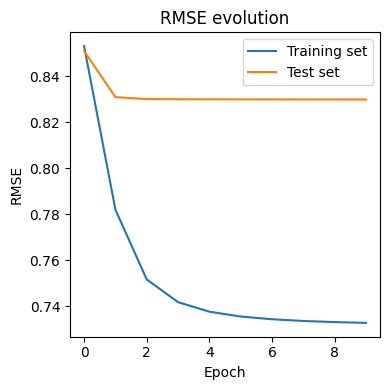

In [7]:
# Rewrite the values to plot
rmse_embed_train1 = np.array([0.853125, 0.782028, 0.751735, 0.741870, 0.737720, 0.735629, 0.734439, 0.733699, 0.733205, 0.732858])
rmse_embed_test1 = np.array([0.850968, 0.830983, 0.830135, 0.830057, 0.830031, 0.830013, 0.829998, 0.829984, 0.829971, 0.829959])

epochs = 10

# plot
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(list(range(epochs)), rmse_embed_train1, label='Training set')
ax.plot(list(range(epochs)), rmse_embed_test1, label='Test set')
ax.set_title('RMSE evolution')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
ax.legend()

plt.tight_layout();
#plt.savefig('rmse_train_test_25.pdf', format='pdf')

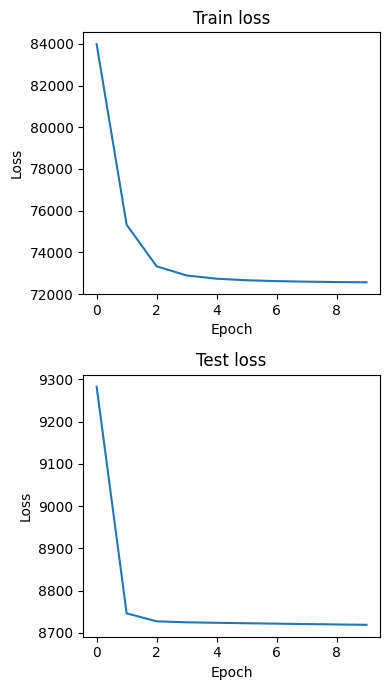

In [10]:
# Rewrite the values to plot
loss_embed_train1 = np.array([83978.006391, 75326.917329, 73335.685654, 72896.040160, 72741.027912, 72667.352651, 72625.583774, 72599.086742, 72580.964719, 72567.927652])
loss_embed_test1 = np.array([9282.735605, 8746.080143, 8727.241659, 8724.917126, 8723.710528, 8722.675006, 8721.698168, 8720.754310, 8719.835193, 8718.937626])

epochs = 10

# plot
fig, ax = plt.subplots(2, 1, figsize=(4, 7))

ax[0].plot(list(range(epochs)), loss_embed_train1)
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(list(range(epochs)), loss_embed_test1)
ax[1].set_title('Test loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

plt.tight_layout();
#plt.savefig('loss_train_test_25.pdf', format='pdf')

### epochs = 10; lambd = 0.01; gamma = 0.0001; tau = 0.9; K = 10

In [47]:
epochs = 10; lambd = 0.01; gamma = 0.0001; tau = 0.9; K = 10

In [48]:
loss_embed_train2, rmse_embed_train2 = compute_loss_and_rmse_with_embeddings(
                                      data_by_usr = data_by_user_train,
  	                                  data_by_itm = data_by_item_train,
                                      user_biases = np.zeros(len(data_by_user_train)),
  	                                  item_biases = np.zeros(len(data_by_item_train)),
                                      lambd = lambd,
                                      gamma = gamma,
                                      tau = tau,
                                      K = K,
                                      epoch = epochs,
                                      )

Epoch 1: loss = 84471.294055, rmse = 0.860392
Epoch 2: loss = 77498.844282, rmse = 0.810134
Epoch 3: loss = 75377.624868, rmse = 0.785781
Epoch 4: loss = 74854.374323, rmse = 0.778206
Epoch 5: loss = 74677.090509, rmse = 0.775254
Epoch 6: loss = 74599.226189, rmse = 0.773867
Epoch 7: loss = 74558.540731, rmse = 0.773126
Epoch 8: loss = 74534.285431, rmse = 0.772689
Epoch 9: loss = 74518.390130, rmse = 0.772411
Epoch 10: loss = 74507.378805, rmse = 0.772223


In [50]:
loss_embed_test2, rmse_embed_test2 = compute_loss_and_rmse_with_embeddings(
                                      data_by_usr = data_by_user_test,
  	                                  data_by_itm = data_by_item_test,
                                      user_biases = np.zeros(len(data_by_user_test)),
  	                                  item_biases = np.zeros(len(data_by_item_test)),
                                      lambd = lambd,
                                      gamma = gamma,
                                      tau = tau,
                                      K = K,
                                      epoch = epochs,
                                      )

Epoch 1: loss = 9312.956728, rmse = 0.853194
Epoch 2: loss = 8723.661829, rmse = 0.830253
Epoch 3: loss = 8705.127554, rmse = 0.829419
Epoch 4: loss = 8702.819631, rmse = 0.829343
Epoch 5: loss = 8701.569016, rmse = 0.829316
Epoch 6: loss = 8700.482223, rmse = 0.829297
Epoch 7: loss = 8699.455375, rmse = 0.829281
Epoch 8: loss = 8698.463455, rmse = 0.829266
Epoch 9: loss = 8697.497889, rmse = 0.829252
Epoch 10: loss = 8696.555194, rmse = 0.829239


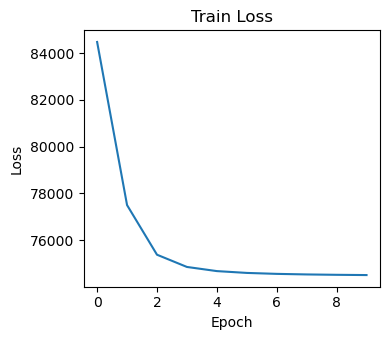

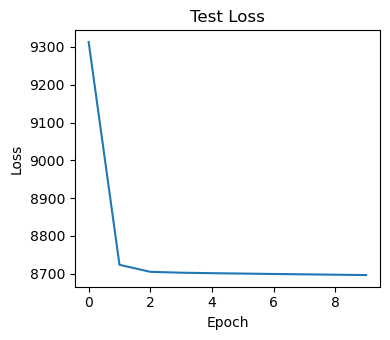

In [33]:
# Rewrite the values to plot
loss_embed_train2 = np.array([84471.294055, 77498.844282, 75377.624868, 74854.374323, 74677.090509, 74599.226189, 74558.540731, 74534.285431, 74518.390130, 74507.378805])
loss_embed_test2 = np.array([9312.956728, 8723.661829, 8705.127554, 8702.819631, 8701.569016, 8700.482223, 8699.455375, 8698.463455, 8697.497889, 8696.555194])

epochs = 10
x = list(range(epochs))

# Plot Train Loss
plt.figure(figsize=(4, 3.5))
plt.plot(x, loss_embed_train2, label='Train Loss')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.savefig('loss_train_25.pdf', format='pdf')

# Plot Test Loss
plt.figure(figsize=(4, 3.5))
plt.plot(x, loss_embed_test2, label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.savefig('loss_test_25.pdf', format='pdf')

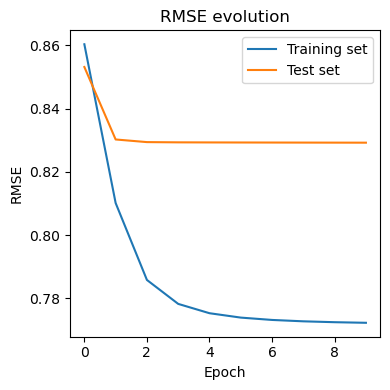

In [5]:
# Rewrite the values to plot
rmse_embed_train2 = np.array([0.860392, 0.810134, 0.785781, 0.778206, 0.775254, 0.773867, 0.773126, 0.772689, 0.772411, 0.772223])
rmse_embed_test2 = np.array([0.853194, 0.830253, 0.829419, 0.829343, 0.829316, 0.829297, 0.829281, 0.829266, 0.829252, 0.829239])

# plot
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(list(range(epochs)), rmse_embed_train2, label='Training set')
ax.plot(list(range(epochs)), rmse_embed_test2, label='Test set')
ax.set_title('RMSE evolution')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
ax.legend()

plt.tight_layout();
plt.savefig('rmse_train_test_25.pdf', format='pdf')

### epochs = 10; lambd = 0.01; gamma = 0.0001; tau = 0.9; K = 20

In [40]:
epochs = 10; lambd = 0.01; gamma = 0.0001; tau = 0.9; K = 20

In [41]:
loss_embed_train2, rmse_embed_train2 = compute_loss_and_rmse_with_embeddings(
                                      data_by_usr = data_by_user_train,
  	                                  data_by_itm = data_by_item_train,
                                      user_biases = np.zeros(len(data_by_user_train)),
  	                                  item_biases = np.zeros(len(data_by_item_train)),
                                      lambd = lambd,
                                      gamma = gamma,
                                      tau = tau,
                                      K = K,
                                      epoch = epochs,
                                      )

Epoch 1: loss = 84266.757575, rmse = 0.857300
Epoch 2: loss = 76446.598511, rmse = 0.797489
Epoch 3: loss = 74391.519135, rmse = 0.770640
Epoch 4: loss = 73889.244300, rmse = 0.762011
Epoch 5: loss = 73701.999686, rmse = 0.758402
Epoch 6: loss = 73609.703129, rmse = 0.756562
Epoch 7: loss = 73558.243553, rmse = 0.755521
Epoch 8: loss = 73527.660425, rmse = 0.754897
Epoch 9: loss = 73508.439421, rmse = 0.754503
Epoch 10: loss = 73495.684855, rmse = 0.754242


In [42]:
loss_embed_test, rmse_embed_test = compute_loss_and_rmse_with_embeddings(
                                      data_by_usr = data_by_user_test,
  	                                  data_by_itm = data_by_item_test,
                                      user_biases = np.zeros(len(data_by_user_test)),
  	                                  item_biases = np.zeros(len(data_by_item_test)),
                                      lambd = lambd,
                                      gamma = gamma,
                                      tau = tau,
                                      K = K,
                                      epoch = epochs,
                                      )

Epoch 1: loss = 9280.041064, rmse = 0.851370
Epoch 2: loss = 8723.630607, rmse = 0.830252
Epoch 3: loss = 8705.088366, rmse = 0.829418
Epoch 4: loss = 8702.783082, rmse = 0.829343
Epoch 5: loss = 8701.533662, rmse = 0.829316
Epoch 6: loss = 8700.447590, rmse = 0.829297
Epoch 7: loss = 8699.421367, rmse = 0.829280
Epoch 8: loss = 8698.430068, rmse = 0.829265
Epoch 9: loss = 8697.465133, rmse = 0.829252
Epoch 10: loss = 8696.523077, rmse = 0.829238


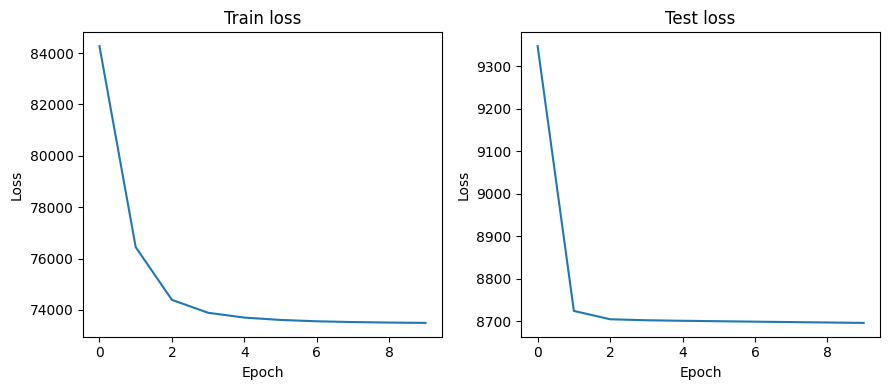

In [45]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

ax[0].plot(list(range(epochs)), loss_embed_train2)
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(list(range(epochs)), loss_embed_test2)
ax[1].set_title('Test loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

plt.tight_layout();

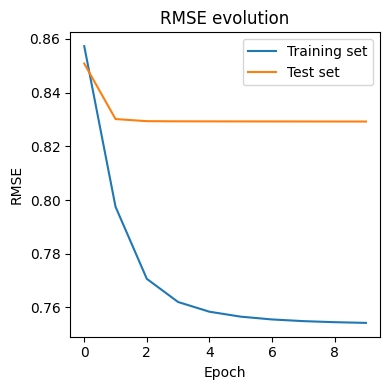

In [46]:
# plot
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(list(range(epochs)), rmse_embed_train2, label='Training set')
ax.plot(list(range(epochs)), rmse_embed_test2, label='Test set')
ax.set_title('RMSE evolution')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
ax.legend()

plt.tight_layout();

## RMSE with different k

In [ ]:
epochs = 10; lambd = 0.01; gamma = 0.0001; tau = 0.9; K = 20

loss_embed_all2, rmse_embed_all2 = compute_loss_and_rmse_with_embeddings(
                                      data_by_usr = data_by_user_index,
  	                                  data_by_itm = data_by_movie_index,
                                      user_biases = np.zeros(len(data_by_user_index)),
  	                                  item_biases = np.zeros(len(data_by_movie_index)),
                                      lambd = lambd,
                                      gamma = gamma,
                                      tau = tau,
                                      K = K,
                                      epoch = epochs,
                                      )

In [ ]:
epochs = 10; lambd = 0.01; gamma = 0.0001; tau = 0.9; K = 50

loss_embed_all5, rmse_embed_all5 = compute_loss_and_rmse_with_embeddings(
                                      data_by_usr = data_by_user_index,
  	                                  data_by_itm = data_by_movie_index,
                                      user_biases = np.zeros(len(data_by_user_index)),
  	                                  item_biases = np.zeros(len(data_by_movie_index)),
                                      lambd = lambd,
                                      gamma = gamma,
                                      tau = tau,
                                      K = K,
                                      epoch = epochs,
                                      )

In [ ]:
epochs = 10; lambd = 0.01; gamma = 0.0001; tau = 0.9; K = 10

loss_embed_all1, rmse_embed_all1 = compute_loss_and_rmse_with_embeddings(
                                      data_by_usr = data_by_user_index,
  	                                  data_by_itm = data_by_movie_index,
                                      user_biases = np.zeros(len(data_by_user_index)),
  	                                  item_biases = np.zeros(len(data_by_movie_index)),
                                      lambd = lambd,
                                      gamma = gamma,
                                      tau = tau,
                                      K = K,
                                      epoch = epochs,
                                      )

In [12]:
import numpy as np
rmsek50 = np.array([0.849811, 0.771006, 0.741553, 0.732356, 0.728587, 0.726705, 0.725627, 0.724946, 0.724485, 0.724156])
rmsek10 = np.array([0.858911, 0.806158, 0.782759, 0.775248, 0.772158, 0.770608, 0.769742, 0.769233, 0.768926, 0.768739])
rmsek20 = np.array([0.854720, 0.789812, 0.764605, 0.756660, 0.753228, 0.751515, 0.750566, 0.749992, 0.749617, 0.749357])

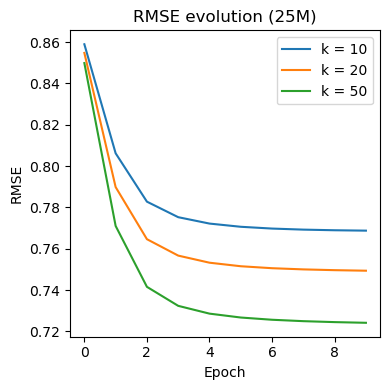

In [14]:
import matplotlib.pyplot as plt

epochs = 10

# plot
fig, ax = plt.subplots(figsize=(4, 4))


ax.plot(list(range(epochs)), rmsek10, label='k = 10')
ax.plot(list(range(epochs)), rmsek20, label='k = 20')
ax.plot(list(range(epochs)), rmsek50, label='k = 50')
ax.set_title('RMSE evolution (25M)')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
ax.legend()

plt.tight_layout();
plt.savefig('rmse_25_k102050.pdf', format='pdf')

# 2D embedding

In [6]:
import numpy as np
import pandas as pd

In [7]:
# Load trained vectors and biases
user_vec = np.load('usr_vect.npy')
user_bi = np.load('usr_bias.npy')
item_vec = np.load('itm_vect.npy')
item_bi = np.load('itm_bias.npy')

In [35]:
item_vec.shape

(59047, 10)

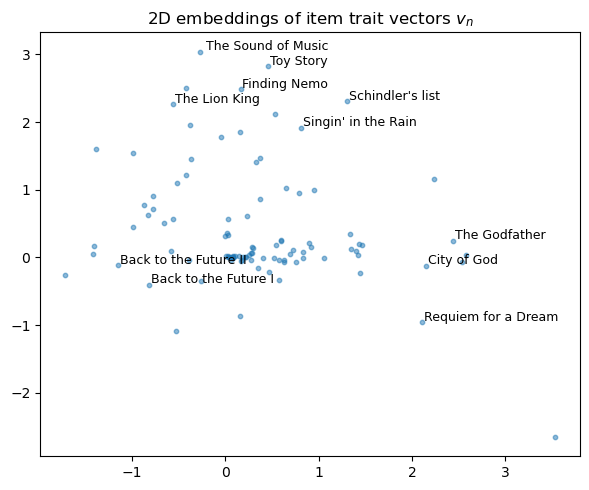

In [36]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Dimensionality reduction with PCA
pca = PCA(n_components=2)
item_vectors_2d = pca.fit_transform(item_vec)

# Mapping indices to movie titles
movie_index = list(range(len(item_vec[:100])))
all_movie_ids = []

for i in movie_index:
    one_movie_id = map_index_to_movie[i]
    all_movie_ids.append(one_movie_id)

# Create a dictionary mapping some movie Id to movie title
movie_labels = {
    1: "Toy Story",
    6377: "Finding Nemo", 
    2011: "Back to the Future I",
    2012: "Back to the Future II",
    3949: "Requiem for a Dream",
    858: "The Godfather",
    1035: " The Sound of Music",
    6016: "City of God",
    899: "Singin' in the Rain",
    527: "Schindler's list",
    364: "The Lion King",
}

# Plot
plt.figure(figsize=(6, 5))
for i, (x, y) in enumerate(item_vectors_2d[:100]):
    plt.scatter(x, y, alpha=0.5, s=10, color='#1f77b4')

for movie_id, label in movie_labels.items():
    idx = all_movie_ids.index(movie_id)  # get index of movie_id in all_movie_ids
    x, y = item_vectors_2d[idx]
    plt.text(x + 0.02, y + 0.02, label, fontsize=9)

plt.title(r"2D embeddings of item trait vectors $v_n$")
plt.tight_layout();

plt.savefig('2d_embedding.pdf', format='pdf')

# Predictions

In [11]:
# Load data
ratings = "ratings25m.csv"
movies = "movies25m.csv"
tags = "tags25m.csv"

ratings_df = pd.read_csv(ratings)
movies_df = pd.read_csv(movies)
tags_df = pd.read_csv(tags)

In [9]:
# Show all possible movie given the title or a part of the title
def list_new_user_possible_movie(possible_title:str):
    return movies_df[movies_df['title'].str.contains(possible_title, case=False)]

# Get the corresponding index of the movie given the Id
def get_movie_index_new_user(index_value):
    return map_movie_to_index[index_value]

# Make predictions / recommendation
def predict_similar_movies(
    index_value_movie,
    rating_movie_new_user,
    number_pred,
    usr_bias = user_bi,
    itm_bias = item_bi,
    itm_vect = item_vec,
    epochs = 5,
    lambd = 0.01,
    gamma = 0.0001,
    tau = 0.9,
    K = 10,
    ):

    movie_index_new_user = get_movie_index_new_user(index_value_movie)
    new_user = [[(movie_index_new_user, rating_movie_new_user)]]
    usr_vect = np.random.normal(0, 1/np.sqrt(K), (len(new_user), K))

    # train new user vector
    for i in range(epochs):
        for m in range(len(new_user)):
            # update user vector
            sum1 = np.zeros((K, K))
            sum2 = np.zeros(K)
            for (n, r) in new_user[m]:
                sum1 += np.outer(itm_vect[n,:], itm_vect[n,:])
                sum2 += itm_vect[n,:] * (r - usr_bias[m] - itm_bias[n])
            u_first_term = lambd * sum1 + tau * np.identity(K)
            usr_vect[m,:] = np.dot(np.linalg.inv(u_first_term), lambd * sum2)

    
    score_for_item = np.zeros(len(data_by_movie_index))
    
    for n in range(len(data_by_movie_index)):
        score_for_item[n] = np.inner(usr_vect, itm_vect[n]).item() + 0.05 * itm_bias[n]

    # select top k score
    top_movies_with_scores = sorted(enumerate(score_for_item), key=lambda x: x[1], reverse=True)[:number_pred]
    top_movies = [i for i, _ in top_movies_with_scores]
    
    # get to k movies
    predict = []
    for i in range(len(top_movies)):
        movie_index = top_movies[i]
        movie_id = map_index_to_movie[movie_index]
        predict.append(movie_id)

    # get the rows corresponding to the movie recommendation / prediction
    new_movies_df = movies_df.loc[movies_df['movieId'].isin(predict)]
    new_movies_df = new_movies_df.drop(new_movies_df[new_movies_df['movieId'] == index_value_movie].index)

    
    return new_movies_df

## Prediction 1: lord of the rings

In [ ]:
# show the list of all movies with the given title or part of the title
list_new_user_possible_movie('lord of the rings')

,movieId,title,genres
2026,2116,"Lord of the Rings, The (1978)",Adventure|Animation|Children|Fantasy
4887,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
5840,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
7028,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy


In [44]:
# show the top recommendations
predict_similar_movies(
    index_value_movie = 4993,
    rating_movie_new_user = 5,
    number_pred = 10
)

,movieId,title,genres
108,110,Braveheart (1995),Action|Drama|War
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
1166,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
1179,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
2537,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi
5840,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
7028,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
9952,33493,Star Wars: Episode III - Revenge of the Sith (...,Action|Adventure|Sci-Fi
61209,205277,Inside Out (1991),Comedy|Drama|Romance


In [53]:
# show the top recommendations
predict_similar_movies(
    index_value_movie = 4993,
    rating_movie_new_user = 5,
    number_pred = 10
)

,movieId,title,genres
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
1166,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
5840,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
7028,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
37139,151989,The Thorn (1971),Comedy
40311,159125,Anybody's Son Will Do,(no genres listed)
40316,159135,The Viking (1931),Action|Adventure|Drama|Romance
40460,159471,Evening's Civil Twilight in Empires of Tin (2008),(no genres listed)
61209,205277,Inside Out (1991),Comedy|Drama|Romance


## Prediction 2: toy story

In [54]:
list_new_user_possible_movie('toy story')

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3021,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
14813,78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX
20497,106022,Toy Story of Terror (2013),Animation|Children|Comedy
22633,115875,Toy Story Toons: Hawaiian Vacation (2011),Adventure|Animation|Children|Comedy|Fantasy
22634,115879,Toy Story Toons: Small Fry (2011),Adventure|Animation|Children|Comedy|Fantasy
24062,120468,Toy Story Toons: Partysaurus Rex (2012),Animation|Children|Comedy
24064,120474,Toy Story That Time Forgot (2014),Animation|Children
59767,201588,Toy Story 4 (2019),Adventure|Animation|Children|Comedy


In [24]:
predict_similar_movies(
    index_value_movie = 1,
    rating_movie_new_user = 5,
    number_pred = 10
)

,movieId,title,genres
359,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
580,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
587,595,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX
3021,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
4201,4306,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...
4780,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
6258,6377,Finding Nemo (2003),Adventure|Animation|Children|Comedy
8246,8961,"Incredibles, The (2004)",Action|Adventure|Animation|Children|Comedy
14813,78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX


## Prediction 3: la la land

In [25]:
list_new_user_possible_movie('la la land')

,movieId,title,genres
42923,164909,La La Land (2016),Comedy|Drama|Romance


In [56]:
predict_similar_movies(
    index_value_movie = 164909,
    rating_movie_new_user = 5,
    number_pred = 10
)

,movieId,title,genres
24620,121919,The Good Mother (2013),Drama|Mystery|Thriller
37139,151989,The Thorn (1971),Comedy
40311,159125,Anybody's Son Will Do,(no genres listed)
40316,159135,The Viking (1931),Action|Adventure|Drama|Romance
40460,159471,Evening's Civil Twilight in Empires of Tin (2008),(no genres listed)
51274,182781,Amori che non sanno stare al mondo (2017),Comedy|Drama
56565,194434,Adrenaline (1990),(no genres listed)
60351,203086,Truth and Justice (2019),Drama
61209,205277,Inside Out (1991),Comedy|Drama|Romance
62355,208859,Screen Play (1992),(no genres listed)


## Prediction 4: titanic

In [27]:
list_new_user_possible_movie('titanic')

,movieId,title,genres
1655,1721,Titanic (1997),Drama|Romance
2067,2157,"Chambermaid on the Titanic, The (Femme de cham...",Romance
3308,3403,Raise the Titanic (1980),Drama|Thriller
3309,3404,Titanic (1953),Action|Drama
4758,4864,Titanica (1992),Documentary|IMAX
15697,82602,Titanic Town (1998),Drama
23692,118916,Titanic (1996),Action|Drama|Romance
33604,143539,Titanic at 100: Mystery Solved (2012),(no genres listed)
45723,170975,The Ten Lives of Titanics the Cat (2007),Action|Children|Drama|Mystery|Thriller
45753,171037,Drain the Titanic (2016),Documentary


In [57]:
predict_similar_movies(
    index_value_movie = 1721,
    rating_movie_new_user = 5,
    number_pred = 10
)

,movieId,title,genres
314,318,"Shawshank Redemption, The (1994)",Crime|Drama
351,356,Forrest Gump (1994),Comedy|Drama|Romance|War
359,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
375,380,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller
475,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
579,587,Ghost (1990),Comedy|Drama|Fantasy|Romance|Thriller
582,590,Dances with Wolves (1990),Adventure|Drama|Western
589,597,Pretty Woman (1990),Comedy|Romance
14102,72998,Avatar (2009),Action|Adventure|Sci-Fi|IMAX


## Prediction 5: avengers

In [58]:
list_new_user_possible_movie('avengers')

,movieId,title,genres
2063,2153,"Avengers, The (1998)",Action|Adventure
17067,89745,"Avengers, The (2012)",Action|Adventure|Sci-Fi|IMAX
22599,115727,Crippled Avengers (Can que) (Return of the 5 D...,Action|Adventure
25058,122892,Avengers: Age of Ultron (2015),Action|Adventure|Sci-Fi
25067,122912,Avengers: Infinity War - Part I (2018),Action|Adventure|Sci-Fi
25068,122914,Avengers: Infinity War - Part II (2019),Action|Adventure|Sci-Fi
30333,135979,Next Avengers: Heroes of Tomorrow (2008),Action|Animation|Children|Sci-Fi
30431,136257,Avengers Grimm (2015),Action|Adventure|Fantasy
34536,145676,3 Avengers (1964),(no genres listed)
35219,147238,The New Adventures of the Elusive Avengers (1968),Action|Adventure|Children


In [62]:
predict_similar_movies(
    index_value_movie = 89745,
    rating_movie_new_user = 5,
    number_pred = 10
)

,movieId,title,genres
3692,3793,X-Men (2000),Action|Adventure|Sci-Fi
5241,5349,Spider-Man (2002),Action|Adventure|Sci-Fi|Thriller
12324,59315,Iron Man (2008),Action|Adventure|Sci-Fi
21348,110102,Captain America: The Winter Soldier (2014),Action|Adventure|Sci-Fi|IMAX
21936,112852,Guardians of the Galaxy (2014),Action|Adventure|Sci-Fi
25058,122892,Avengers: Age of Ultron (2015),Action|Adventure|Sci-Fi
25063,122904,Deadpool (2016),Action|Adventure|Comedy|Sci-Fi
25067,122912,Avengers: Infinity War - Part I (2018),Action|Adventure|Sci-Fi
61209,205277,Inside Out (1991),Comedy|Drama|Romance


## Prediction 6: dune (1984)

In [63]:
list_new_user_possible_movie('dune')

,movieId,title,genres
1932,2021,Dune (1984),Adventure|Sci-Fi
3131,3224,Woman in the Dunes (Suna no onna) (1964),Drama
21575,111235,Jodorowsky's Dune (2013),Documentary|Sci-Fi
34710,146092,Be Dune Saade Char (2009),(no genres listed)
44291,167912,Dune Warriors (1991),Fantasy


In [64]:
predict_similar_movies(
    index_value_movie = 2021,
    rating_movie_new_user = 5,
    number_pred = 10
)

,movieId,title,genres
536,541,Blade Runner (1982),Action|Sci-Fi|Thriller
903,924,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi
1475,1527,"Fifth Element, The (1997)",Action|Adventure|Comedy|Sci-Fi
2480,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
37139,151989,The Thorn (1971),Comedy
40311,159125,Anybody's Son Will Do,(no genres listed)
40316,159135,The Viking (1931),Action|Adventure|Drama|Romance
40460,159471,Evening's Civil Twilight in Empires of Tin (2008),(no genres listed)
61209,205277,Inside Out (1991),Comedy|Drama|Romance
62355,208859,Screen Play (1992),(no genres listed)


## Prediction 7: one day (2011)

In [65]:
list_new_user_possible_movie('one day')

,movieId,title,genres
3885,3989,One Day in September (1999),Documentary
16735,88179,One Day (2011),Drama|Romance
28631,132134,15 Years and One Day (2013),Drama
41154,161056,One Day Like Rain (2007),Drama|Sci-Fi
47112,173829,One Day Since Yesterday: Peter Bogdanovich & t...,Documentary
49958,179973,One Day (2012),(no genres listed)
51405,183069,One Day in August (2002),(no genres listed)
56924,195233,One Day (2018),Drama
60080,202409,One Day (2017),Drama|Fantasy


In [66]:
predict_similar_movies(
    index_value_movie = 88179,
    rating_movie_new_user = 5,
    number_pred = 10
)

,movieId,title,genres
24620,121919,The Good Mother (2013),Drama|Mystery|Thriller
37139,151989,The Thorn (1971),Comedy
40311,159125,Anybody's Son Will Do,(no genres listed)
40316,159135,The Viking (1931),Action|Adventure|Drama|Romance
40460,159471,Evening's Civil Twilight in Empires of Tin (2008),(no genres listed)
51274,182781,Amori che non sanno stare al mondo (2017),Comedy|Drama
56565,194434,Adrenaline (1990),(no genres listed)
60351,203086,Truth and Justice (2019),Drama
61209,205277,Inside Out (1991),Comedy|Drama|Romance
62355,208859,Screen Play (1992),(no genres listed)


## Prediction 8:  harry potter

In [97]:
list_new_user_possible_movie('harry potter')

,movieId,title,genres
4790,4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy
5704,5816,Harry Potter and the Chamber of Secrets (2002),Adventure|Fantasy
7742,8368,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy|IMAX
10408,40815,Harry Potter and the Goblet of Fire (2005),Adventure|Fantasy|Thriller|IMAX
11700,54001,Harry Potter and the Order of the Phoenix (2007),Adventure|Drama|Fantasy|IMAX
13512,69844,Harry Potter and the Half-Blood Prince (2009),Adventure|Fantasy|Mystery|Romance|IMAX
15538,81834,Harry Potter and the Deathly Hallows: Part 1 (...,Action|Adventure|Fantasy|IMAX
16718,88125,Harry Potter and the Deathly Hallows: Part 2 (...,Action|Adventure|Drama|Fantasy|Mystery|IMAX
53126,186777,The Greater Good - Harry Potter Fan Film (2013),Action|Adventure|Fantasy


In [98]:
predict_similar_movies(
    index_value_movie = 4896,
    rating_movie_new_user = 5,
    number_pred = 10
)

,movieId,title,genres
5704,5816,Harry Potter and the Chamber of Secrets (2002),Adventure|Fantasy
7742,8368,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy|IMAX
10408,40815,Harry Potter and the Goblet of Fire (2005),Adventure|Fantasy|Thriller|IMAX
11700,54001,Harry Potter and the Order of the Phoenix (2007),Adventure|Drama|Fantasy|IMAX
13512,69844,Harry Potter and the Half-Blood Prince (2009),Adventure|Fantasy|Mystery|Romance|IMAX
15538,81834,Harry Potter and the Deathly Hallows: Part 1 (...,Action|Adventure|Fantasy|IMAX
16718,88125,Harry Potter and the Deathly Hallows: Part 2 (...,Action|Adventure|Drama|Fantasy|Mystery|IMAX
40311,159125,Anybody's Son Will Do,(no genres listed)
61209,205277,Inside Out (1991),Comedy|Drama|Romance


## Prediction 9: the godfather

In [100]:
list_new_user_possible_movie('godfather')

,movieId,title,genres
840,858,"Godfather, The (1972)",Crime|Drama
1190,1221,"Godfather: Part II, The (1974)",Crime|Drama
1934,2023,"Godfather: Part III, The (1990)",Crime|Drama|Mystery|Thriller
7894,8607,Tokyo Godfathers (2003),Adventure|Animation|Drama
8461,25934,3 Godfathers (1948),Drama|Western
19261,100180,"Last Godfather, The (2010)",Comedy
20640,106704,Disco Godfather (1979),Action|Crime|Drama
24459,121519,The New Godfathers (1979),Crime
25505,123880,The Black Godfather (1974),Action|Crime|Thriller
25914,124791,Three Godfathers (1936),Drama|Western


In [103]:
predict_similar_movies(
    index_value_movie = 858,
    rating_movie_new_user = 5,
    number_pred = 10
)

,movieId,title,genres
49,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
891,912,Casablanca (1942),Drama|Romance
1182,1213,Goodfellas (1990),Crime|Drama
1190,1221,"Godfather: Part II, The (1974)",Crime|Drama
37139,151989,The Thorn (1971),Comedy
40311,159125,Anybody's Son Will Do,(no genres listed)
40316,159135,The Viking (1931),Action|Adventure|Drama|Romance
40460,159471,Evening's Civil Twilight in Empires of Tin (2008),(no genres listed)
61209,205277,Inside Out (1991),Comedy|Drama|Romance


## Prediction 10: back to the future

In [11]:
list_new_user_possible_movie('back to the future')

,movieId,title,genres
1237,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi
1922,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi
1923,2012,Back to the Future Part III (1990),Adventure|Comedy|Sci-Fi|Western
19761,102666,Ivan Vasilievich: Back to the Future (Ivan Vas...,Adventure|Comedy


In [18]:
predict_similar_movies(
    index_value_movie = 2011,
    rating_movie_new_user = 5,
    number_pred = 10
)

,movieId,title,genres
351,356,Forrest Gump (1994),Comedy|Drama|Romance|War
475,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
581,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi
1237,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi
1923,2012,Back to the Future Part III (1990),Adventure|Comedy|Sci-Fi|Western
2624,2716,Ghostbusters (a.k.a. Ghost Busters) (1984),Action|Comedy|Sci-Fi
40311,159125,Anybody's Son Will Do,(no genres listed)
40316,159135,The Viking (1931),Action|Adventure|Drama|Romance
61209,205277,Inside Out (1991),Comedy|Drama|Romance


## Prediction 11: Schindler's list

In [13]:
list_new_user_possible_movie('schindler')

,movieId,title,genres
522,527,Schindler's List (1993),Drama|War


In [14]:
predict_similar_movies(
    index_value_movie = 527,
    rating_movie_new_user = 5,
    number_pred = 10
)

,movieId,title,genres
108,110,Braveheart (1995),Action|Drama|War
314,318,"Shawshank Redemption, The (1994)",Crime|Drama
351,356,Forrest Gump (1994),Comedy|Drama|Romance|War
582,590,Dances with Wolves (1990),Adventure|Drama|Western
840,858,"Godfather, The (1972)",Crime|Drama
1939,2028,Saving Private Ryan (1998),Action|Drama|War
4887,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
7028,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
61209,205277,Inside Out (1991),Comedy|Drama|Romance


## Prediction 12: saving private ryan

In [141]:
list_new_user_possible_movie('saving private ryan')

,movieId,title,genres
1939,2028,Saving Private Ryan (1998),Action|Drama|War


In [142]:
predict_similar_movies(
    index_value_movie = 2028,
    rating_movie_new_user = 5,
    number_pred = 10
)

,movieId,title,genres
108,110,Braveheart (1995),Action|Drama|War
148,150,Apollo 13 (1995),Adventure|Drama|IMAX
351,356,Forrest Gump (1994),Comedy|Drama|Romance|War
522,527,Schindler's List (1993),Drama|War
3479,3578,Gladiator (2000),Action|Adventure|Drama
40311,159125,Anybody's Son Will Do,(no genres listed)
40316,159135,The Viking (1931),Action|Adventure|Drama|Romance
40460,159471,Evening's Civil Twilight in Empires of Tin (2008),(no genres listed)
61209,205277,Inside Out (1991),Comedy|Drama|Romance


## Prediction 13: the sound of music

In [14]:
list_new_user_possible_movie('sound of music')

,movieId,title,genres
1012,1035,"Sound of Music, The (1965)",Musical|Romance
28494,131834,The Sound of Music Live (2013),Children|Drama


In [15]:
predict_similar_movies(
    index_value_movie = 1035,
    rating_movie_new_user = 5,
    number_pred = 10
)

,movieId,title,genres
359,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
580,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
587,595,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX
898,919,"Wizard of Oz, The (1939)",Adventure|Children|Fantasy|Musical
1655,1721,Titanic (1997),Drama|Romance
40311,159125,Anybody's Son Will Do,(no genres listed)
40316,159135,The Viking (1931),Action|Adventure|Drama|Romance
40460,159471,Evening's Civil Twilight in Empires of Tin (2008),(no genres listed)
61209,205277,Inside Out (1991),Comedy|Drama|Romance


## Prediction 14: the boy who harnessed the wind

In [18]:
list_new_user_possible_movie('who harnessed the')

,movieId,title,genres
58830,199476,The Boy Who Harnessed the Wind (2019),Drama


In [19]:
predict_similar_movies(
    index_value_movie = 199476,
    rating_movie_new_user = 5,
    number_pred = 10
)

,movieId,title,genres
24620,121919,The Good Mother (2013),Drama|Mystery|Thriller
37139,151989,The Thorn (1971),Comedy
40311,159125,Anybody's Son Will Do,(no genres listed)
40316,159135,The Viking (1931),Action|Adventure|Drama|Romance
40460,159471,Evening's Civil Twilight in Empires of Tin (2008),(no genres listed)
51274,182781,Amori che non sanno stare al mondo (2017),Comedy|Drama
56565,194434,Adrenaline (1990),(no genres listed)
60351,203086,Truth and Justice (2019),Drama
61209,205277,Inside Out (1991),Comedy|Drama|Romance
62355,208859,Screen Play (1992),(no genres listed)
